Diseases classification model with decision trees - in this model I will use clusters as classification labels. Clusterss were created with k-means analysis.

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [235]:
# Load dataset
scaled_df = pd.read_csv('../Data/scaled_df_clusters.csv')

In [236]:
# Checking prepered dataset
scaled_df.head()

,Age,Gender,Sickness_Duration_Months,RBC_Count,Hemoglobin,Hematocrit,MCV,MCH,MCHC,RDW,Reticulocyte_Count,WBC_Count,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,PLT_Count,MPV,ANA,Esbach,MBL_Level,ESR,C3,C4,CRP,Anti-dsDNA,Anti-Sm,Rheumatoid factor,ACPA,Anti-TPO,Anti-Tg,Anti-SMA,Low-grade fever,Fatigue or chronic tiredness,Dizziness,Weight loss,Rashes and skin lesions,Stiffness in the joints,Brittle hair or hair loss,Dry eyes and/or mouth,General unwell feeling,Joint pain,Anti_dsDNA,Anti_enterocyte_antibodies,ASCA,Anti_BP180,ASMA,IgG_IgE_receptor,Anti_SRP,Anti_La_SSB,Anti_Jo1,Anti_desmoglein_1,EMA,Anti_type_VII_collagen,C1_inhibitor,Anti_epidermal_basement_membrane_IgA,Anti_OmpC,pANCA,Anti_tissue_transglutaminase,anti_Scl_70,Anti_Mi2,Anti_parietal_cell,Progesterone_antibodies,Anti_Sm,Diseases_ID,Diseases_eng,Diseases_group,Cluster
0,0.712121,1,0.218487,0.016667,0.424000,0.596429,0.828276,0.966667,0.424,0.226667,0.632,0.534817,0.938889,0.160000,0.90750,0.7550,0.58,0.822857,0.216,1,0.482759,0.894444,0.816327,0.836364,0.78,0.310,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,Linear IgA disease,7,7
1,0.651515,0,0.890756,0.612500,0.630667,0.456429,0.661887,0.656667,0.014,0.811111,0.284,0.574072,0.594000,0.922667,0.08250,0.1675,0.66,0.968049,0.384,1,0.572414,0.488889,0.469388,0.000000,0.14,0.273,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,Dermatomyositis,4,6
2,0.363636,0,0.050420,0.170833,0.488000,0.457857,0.441814,0.571667,0.922,0.893333,0.872,0.589949,0.464889,0.540333,0.62000,0.8300,0.57,1.000000,0.140,1,0.824138,0.677778,0.897959,0.500000,0.32,0.102,1,0,1,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ord's thyroiditis,8,3
3,0.409091,1,0.092437,0.445833,0.661333,0.292857,0.364788,0.236667,0.586,0.142222,0.516,0.462308,0.248889,0.620000,0.56750,0.5300,0.22,0.074418,0.790,1,0.224138,0.472222,0.510204,0.600000,0.32,0.545,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,Restless legs syndrome,5,0
4,0.909091,1,0.252101,0.575000,0.161333,0.112857,0.605202,0.645000,0.058,0.922222,0.368,0.719465,0.351556,0.919000,0.13125,0.9000,0.90,0.918556,0.702,1,0.227586,0.522222,0.857143,0.300000,0.30,0.105,0,1,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,Autoimmune polyendocrine syndrome type 2 (APS2),8,1


In [237]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12499 entries, 0 to 12498
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   12499 non-null  float64
 1   Gender                                12499 non-null  int64  
 2   Sickness_Duration_Months              12499 non-null  float64
 3   RBC_Count                             12499 non-null  float64
 4   Hemoglobin                            12499 non-null  float64
 5   Hematocrit                            12499 non-null  float64
 6   MCV                                   12499 non-null  float64
 7   MCH                                   12499 non-null  float64
 8   MCHC                                  12499 non-null  float64
 9   RDW                                   12499 non-null  float64
 10  Reticulocyte_Count                    12499 non-null  float64
 11  WBC_Count      

In [238]:
# Checking the number of cases in each cluster
scaled_df['Cluster'].value_counts()

Cluster
4    2594
5    1677
7    1554
1    1291
3    1263
2    1162
8    1150
0    1056
6     752
Name: count, dtype: int64

Training the base model with the full set of features. That allows me for assessing the model's baseline potential

In [239]:
# Preparing features and labels DataFrames
X = scaled_df.drop(columns=['Diseases_group', 'Diseases_ID', 'Diseases_eng', 'Cluster'])
y = scaled_df['Cluster']

In [240]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [242]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [243]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [244]:
print("Best parameters:", random_search.best_params_)
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Classification report:
              precision    recall  f1-score   support

           0       0.28      0.28      0.28       204
           1       0.27      0.29      0.28       248
           2       0.49      0.57      0.53       245
           3       0.35      0.26      0.30       263
           4       0.99      1.00      1.00       518
           5       0.19      0.17      0.18       327
           6       0.24      0.28      0.26       169
           7       0.52      0.58      0.55       296
           8       0.27      0.26      0.26       230

    accuracy                           0.48      2500
   macro avg       0.40      0.41      0.40      2500
weighted avg       0.47      0.48      0.47      2500

Confusion matrix:
[[ 57  37  12  26   0  34  19  19   0]
 [ 31  71  21   0   0  41  25  26  33]
 [ 11  21 140  14   2  24  10  10  13]
 [ 32   0  23  69   0  46  21  33  39]
 [  0   0   0 

Now I have classification model with best hyperparameters and based on all features I can optimize the features to find the best subset using RFE technique

In [245]:
# Searching for optimal number of features
metrics_results = []

for n_features in range(5, X_train.shape[1] + 1, 5): 
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=n_features)
    rfe.fit(X_train_res, y_train_res)
    
    X_train_rfe = rfe.transform(X_train_res)
    X_test_rfe = rfe.transform(X_test)
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_rfe, y_train_res)
    
    y_pred = model.predict(X_test_rfe)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    
    metrics_results.append({'n_features': n_features, 'accuracy': acc, 'precision': prec, 'recall': rec})

metrics_df = pd.DataFrame(metrics_results)

optimal_n_features = metrics_df.loc[metrics_df['accuracy'].idxmax(), 'n_features']
print(f"Optimal number of features: {optimal_n_features}")


Optimal number of features: 50


In [246]:
# Tuning RFE with the optimal number of features
rfe_optimal = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=optimal_n_features)
rfe_optimal.fit(X_train_res, y_train_res)

RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=50)

In [247]:
# Feature ranking and most important feature selection
feature_ranking = pd.DataFrame({
    'feature': X_train.columns, 
    'ranking': rfe_optimal.ranking_,
    'support': rfe_optimal.support_
}).sort_values(by='ranking')

selected_features = feature_ranking[feature_ranking['support']].copy()

After I faund an optimal subset of features I can cross-validate my model to check it's stability and generalization.

In [248]:
# Cross validation of the final model
X_train_rfe_optimal = rfe_optimal.transform(X_train_res)
X_test_rfe_optimal = rfe_optimal.transform(X_test)

final_model = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(final_model, X_train_rfe_optimal, y_train_res, cv=5, scoring='accuracy')

final_model.fit(X_train_rfe_optimal, y_train_res)

y_pred_final = final_model.predict(X_test_rfe_optimal)

print(f"Cross-validated Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))
print("Final Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Cross-validated Accuracy: 0.5700 (+/- 0.0048)
Final Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.26      0.25       204
           1       0.29      0.33      0.31       248
           2       0.51      0.60      0.55       245
           3       0.38      0.30      0.33       263
           4       0.99      1.00      1.00       518
           5       0.20      0.15      0.17       327
           6       0.22      0.24      0.23       169
           7       0.54      0.57      0.56       296
           8       0.32      0.31      0.32       230

    accuracy                           0.48      2500
   macro avg       0.41      0.42      0.41      2500
weighted avg       0.48      0.48      0.48      2500

Final Confusion Matrix:
[[ 53  38  16  25   0  38  21  13   0]
 [ 34  83  22   0   0  31  19  27  32]
 [ 17  17 147  16   2  17  12   7  10]
 [ 39   0  19  78   0  44  23  25  35]
 [  0   0   0   0 518   0   0   0   0]
 

To provide insight into the significance of individual variables in the final model, feature importance chart can be created

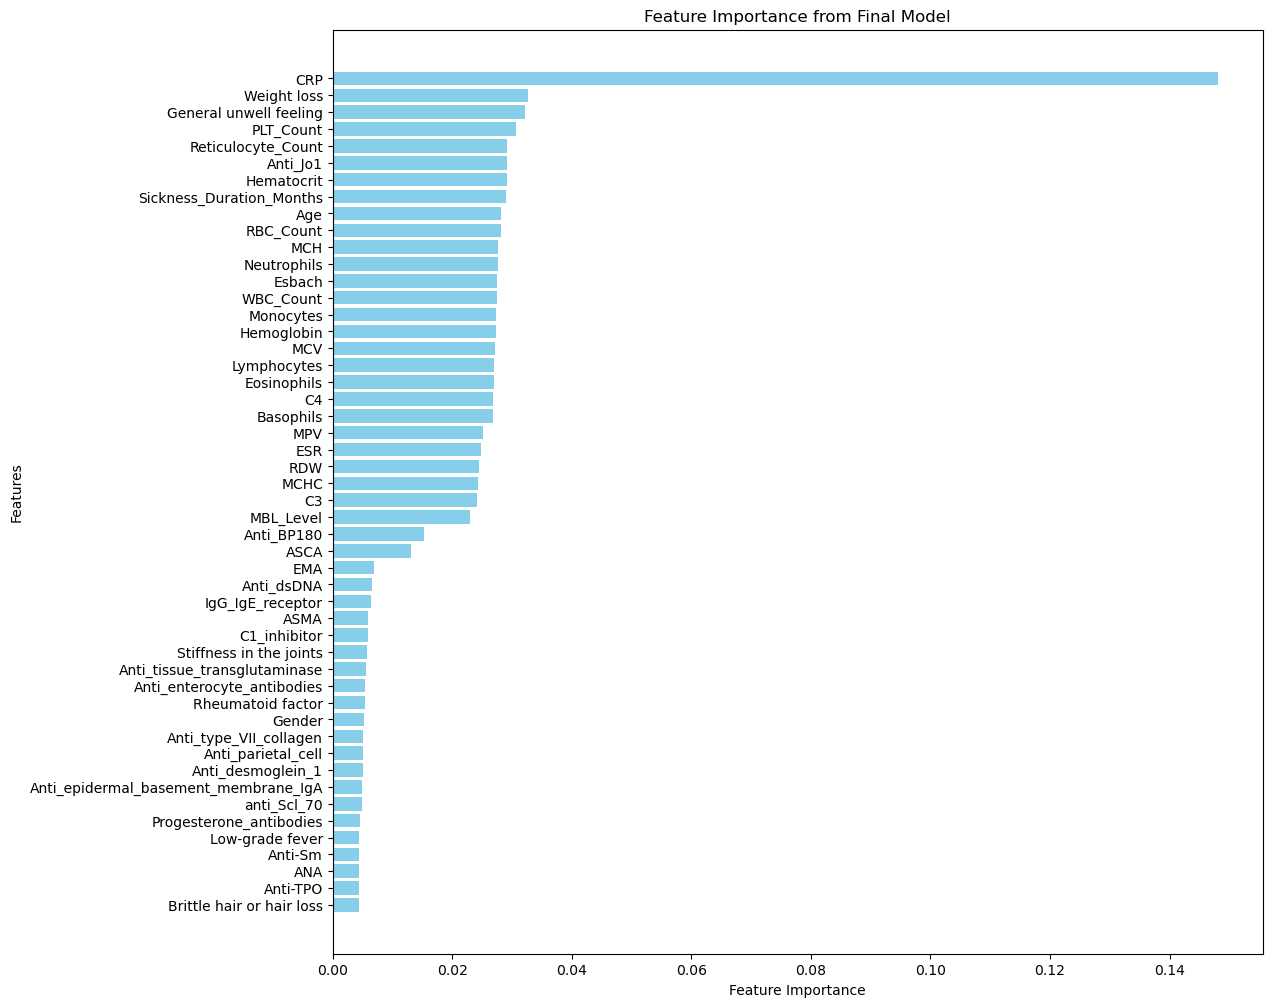

In [249]:
selected_features_names = X_train.columns[rfe_optimal.support_]

feature_importances = pd.DataFrame({
    'feature': selected_features_names,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 12))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Final Model')
plt.gca().invert_yaxis()
plt.show()


Final classification model report analysis: - poprawić
- Precision: Indicates the percentage of predictions for a given class that were correct. For most classes, precision ranges from low values (e.g., class 5 – 0.20) to high values (class 4 – 0.99). 
- Recall: Indicates the percentage of actual cases of a given class that were correctly classified. Class 4 was perfectly recognized, but other classes have low values. Especially low recall for classes 5, 6, and 0 means that patients belonging to these groups may be overlooked. This is potentially risky and requires improvement of the model or creating model without those classes 
- F1-score: It is the harmonic mean of precision and recall, providing an overall measure of classification quality for a given class. Again F1-score is particullary low for classes 5, 6 and 0.
- Overall accuracy is 48%, which suggests that the model performs moderately, especially for minority classes.
- Low accuracy on the test set (0.48) indicates that the model may have difficulty with generalization. Higher cross-validated accuracy (0.57) suggests that the model performs better on random splits, but it is still not highly effective.

Confusion matrix analysis: Class 4 (the largest class - patients with no diseases) was classified perfectly. However, other classes, especially classes 0, 5 and 6, are confused with the others.

This classification model was created based on the labels of the grouping variable generated using k-means clustering. This model will be compared with classification model where the labels of the classification variable were defined based on domain (medical) knowledge. 